In [1]:
import itertools
import matplotlib.pyplot as plt
from brian2.only import *
import seaborn as sns

import numpy_ as np
import spatial, model, inputs, readout, digest

from spike_utils import iterspikes
from plot_utils import colors


rng = np.random.default_rng(368741)

N = 100
inhibitory_ratio = .2

from conf.params import params
params.update({
    # Paradigm
    'settling_period': 1*msecond,
    'sequence_length': 5,
    'sequence_count': 10,
    'fully_random_msc': True,
    'fully_random_oddball': True,
    'ISI': 100*ms
})

In [2]:
_new_black = '#373737'
sns.set_theme(style='ticks', font_scale=0.75, rc={
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'DejaVu Sans'],
    'svg.fonttype': 'none',
    'text.usetex': False,
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'font.size': 8,
    'axes.labelsize': 8,
    'axes.titlesize': 9,
    'axes.labelpad': 2,
    'axes.linewidth': 0.5,
    'axes.titlepad': 4,
    'lines.linewidth': 0.5,
    'legend.fontsize': 8,
    'legend.title_fontsize': 9,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'xtick.major.size': 2,
    'xtick.major.pad': 1,
    'xtick.major.width': 0.5,
    'ytick.major.size': 2,
    'ytick.major.pad': 1,
    'ytick.major.width': 0.5,
    'xtick.minor.size': 2,
    'xtick.minor.pad': 1,
    'xtick.minor.width': 0.5,
    'ytick.minor.size': 2,
    'ytick.minor.pad': 1,
    'ytick.minor.width': 0.5,

    # Avoid black unless necessary
    'text.color': _new_black,
    'patch.edgecolor': _new_black,
    'patch.force_edgecolor': False, # Seaborn turns on edgecolors for histograms by default and I don't like it
    'hatch.color': _new_black,
    'axes.edgecolor': _new_black,
    # 'axes.titlecolor': _new_black # should fallback to text.color
    'axes.labelcolor': _new_black,
    'xtick.color': _new_black,
    'ytick.color': _new_black
})

In [3]:
X, Y, W, D = spatial.create_weights(params, rng)
Xstim, Ystim = spatial.create_stimulus_locations(params)
A, B = params['N_stimuli']-1, rng.choice(params['N_stimuli']-1)

Net = model.create_network(X, Y, Xstim, Ystim, W, D, params,
    reset_dt=inputs.get_episode_duration(params), extras=('u', 'neuron_xr'),
    state_dt=params['dt'], state_vars=['v', 'u', 'th_adapt', 'neuron_xr', 'g_exc', 'g_inh', 'vsyn'])
rundata = readout.setup_run(Net, params, rng, {'A': A, 'B': B})
Net.run(rundata['runtime'])

readout.get_results(Net, params, rundata, processing=True)
stimulated_neurons = spatial.get_stimulated(X, Y, Xstim, Ystim, params)[0]

WARNING    'dt' is an internal variable of group 'Exc', but also exists in the group-specific namespace with the value 1. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'dt' is an internal variable of group 'Inh', but also exists in the group-specific namespace with the value 1. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


In [ ]:
p = 2
criterion = np.sum(rundata['dynamics'][0]['A']['std']['v'][:params['N_exc'], p]*volt > params['v_threshold'], -1)
criterion[stimulated_neurons[stimulated_neurons<params['N_exc']]] = 0
sorting = np.argsort(-criterion)
for j in sorting[:11]:
    plt.axhline(params['v_threshold'], color='grey')
    plt.plot(rundata['dynamics'][0]['A']['std']['th_adapt'][j, p]*volt + params['v_threshold'])
    plt.plot(rundata['dynamics'][0]['A']['std']['v'][j, p]*volt)
    plt.plot(rundata['dynamics'][0]['A']['std']['u'][j, p]*volt)
    plt.title(j)
    plt.show()

# Networked example

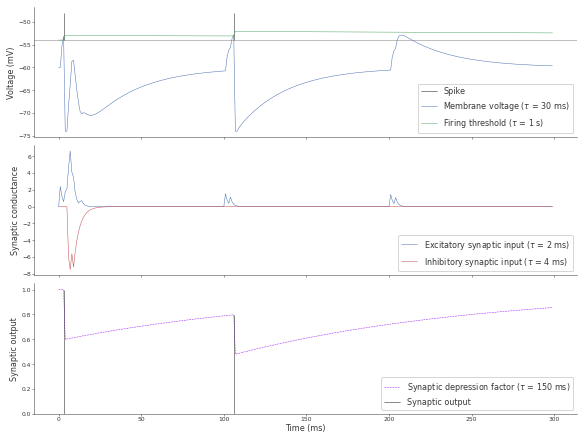

In [5]:
npulses = 3
legend_loc = 'lower right'
for j in sorting[:1]:
    u, v, th_adapt, xr, g_exc, g_inh, vsyn = [
        np.concatenate([
            rundata['dynamics'][0]['A']['std'][k][j, p]
            for p in range(npulses)], axis=-1) * unit
        for k, unit in zip(('u','v','th_adapt','neuron_xr','g_exc','g_inh','vsyn'), (volt, volt, volt, 1, 1, 1, volt))]
    spikes = np.concatenate([
        rundata['spikes'][0]['A']['std']['pulsed_t'][p][rundata['spikes'][0]['A']['std']['pulsed_i'][p]==j] + p*params['ISI']
        for p in range(npulses)])
    time = np.arange(0*second, npulses*params['ISI']-params['dt']/2, params['dt'])

    fig, axs = plt.subplots(3, figsize=(8,6), sharex=True, constrained_layout=True)
    axs[0].axhline(params['v_threshold']/mV, color='grey', lw=1, alpha=.5)
    for spike in spikes:
        axs[0].vlines(spike/ms, params['v_threshold']/mV, (params['v_rest']+2*(params['v_threshold']-params['v_rest']))/mV, color='k')
    axs[0].plot([], color='k', label='Spike')
    axs[0].plot(time/ms, v/mV, label='Membrane voltage ($\\tau$ = 30 ms)')
    axs[0].plot(time/ms, (th_adapt + params['v_threshold'])/mV, label='Firing threshold ($\\tau$ = 1 s)', c=colors['Threshold'])
    axs[0].legend(loc=legend_loc)
    axs[0].set_ylabel('Voltage (mV)')

    axs[1].plot(time/ms, g_exc, label='Excitatory synaptic input ($\\tau$ = 2 ms)', c='b')
    axs[1].plot(time/ms, -g_inh, label='Inhibitory synaptic input ($\\tau$ = 4 ms)', c='r')
    axs[1].legend(loc=legend_loc)
    axs[1].set_ylabel('Synaptic conductance')

    axs[2].plot(time/ms, xr, '--', c=colors['Depression'], label='Synaptic depression factor ($\\tau$ = 150 ms)')
    axs[2].vlines(spikes/ms, 0, xr[(((spikes+params['dt']/2))/params['dt']).astype(int)], color='k')
    axs[2].plot([], c='k', label='Synaptic output')
    axs[2].set_ylim(bottom=0)
    axs[2].legend(loc=legend_loc)
    axs[2].set_ylabel('Synaptic output')

    plt.xlabel('Time (ms)')
    sns.despine()

In [6]:
tslice = slice(90, None)

depression = u-v
threshold = th_adapt
activity = u-params['v_threshold']
synapse = vsyn + depression

v_noTA = params['v_threshold'] - v
v_noSTD = params['v_threshold']+th_adapt - u

def get_steps(mask):
    steps = np.flatnonzero(np.diff(mask[tslice])) + int(time[tslice][0]/ms) + 1
    if mask[tslice][0]:
        steps = np.concatenate([[0], steps])
    if mask[tslice][-1]:
        steps = np.concatenate([steps, [len(mask[tslice])]])
    return steps

steps = get_steps(activity > 0)
steps_noTA = get_steps(v_noTA < 0)
steps_noSTD = get_steps(v_noSTD < 0)

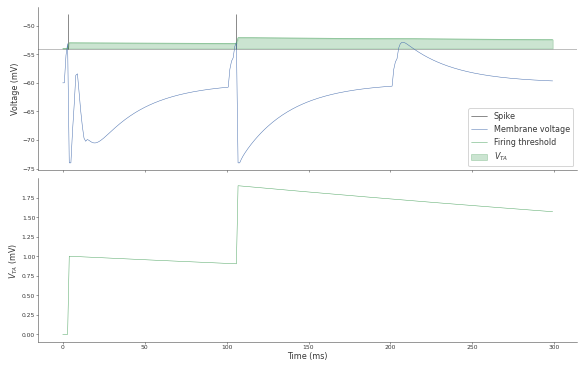

In [7]:
fig, axs = plt.subplots(2, figsize=(8,5), sharex=True, constrained_layout=True)
axs[0].axhline(params['v_threshold']/mV, color='grey', lw=1, alpha=.5)
for spike in spikes:
    axs[0].vlines(spike/ms, params['v_threshold']/mV, (params['v_rest']+2*(params['v_threshold']-params['v_rest']))/mV, color='k')
axs[0].plot([], color='k', label='Spike')
axs[0].plot(time/ms, v/mV, label='Membrane voltage')
axs[0].plot(time/ms, (th_adapt + params['v_threshold'])/mV, label='Firing threshold', c=colors['Threshold'])
axs[0].fill_between(time/ms, params['v_threshold']/mV, (th_adapt + params['v_threshold'])/mV,
                    label='$V_{TA}$', color=colors['Threshold'], alpha=.3)
axs[0].legend(loc=legend_loc)
axs[0].set_ylabel('Voltage (mV)')

axs[1].plot(time/ms, th_adapt/mV, label='$V_TA$', c=colors['Threshold'])
axs[1].set_ylabel('$V_{TA}$ (mV)')

plt.xlabel('Time (ms)')
sns.despine()

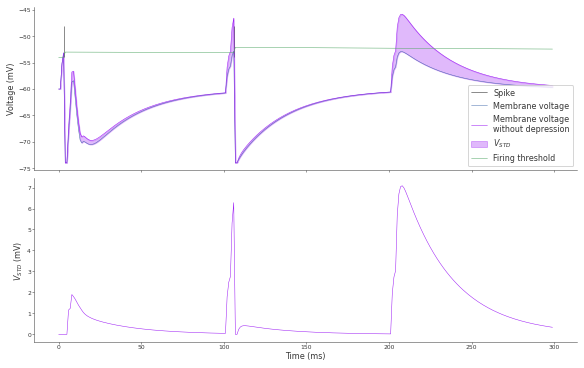

In [8]:
fig, axs = plt.subplots(2, figsize=(8,5), sharex=True, constrained_layout=True)
for spike in spikes:
    axs[0].vlines(spike/ms, params['v_threshold']/mV, (params['v_rest']+2*(params['v_threshold']-params['v_rest']))/mV, color='k')
axs[0].plot([], color='k', label='Spike')
axs[0].plot(time/ms, v/mV, label='Membrane voltage')
axs[0].plot(time/ms, u/mV, label='Membrane voltage\nwithout depression', color=colors['Depression'])
axs[0].fill_between(time/ms, v/mV, u/mV, color=colors['Depression'], alpha=.3, label='$V_{STD}$')
axs[0].plot(time/ms, (th_adapt + params['v_threshold'])/mV, label='Firing threshold', c=colors['Threshold'])
axs[0].legend(loc=legend_loc)
axs[0].set_ylabel('Voltage (mV)')

axs[1].plot(time/ms, depression/mV, c=colors['Depression'])
axs[1].set_ylabel('$V_{STD}$ (mV)')

plt.xlabel('Time (ms)')
sns.despine()

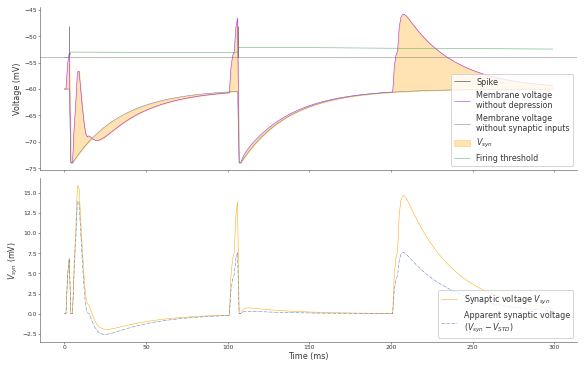

In [9]:
fig, axs = plt.subplots(2, figsize=(8,5), sharex=True, constrained_layout=True)
axs[0].axhline(params['v_threshold']/mV, color='grey', lw=1, alpha=.5)
for spike in spikes:
    axs[0].vlines(spike/ms, params['v_threshold']/mV, (params['v_rest']+2*(params['v_threshold']-params['v_rest']))/mV, color='k')
axs[0].plot([], color='k', label='Spike')
axs[0].plot(time/ms, u/mV, label='Membrane voltage\nwithout depression', color=colors['Depression'])
axs[0].plot(time/ms, (u-synapse)/mV, label='Membrane voltage\nwithout synaptic inputs', color=colors['Reset'])
axs[0].fill_between(time/ms, u/mV, (u-synapse)/mV, label='$V_{syn}$', color=colors['Synapses'], alpha=.3)
axs[0].plot(time/ms, (th_adapt + params['v_threshold'])/mV, label='Firing threshold', c=colors['Threshold'])
axs[0].legend(loc=legend_loc)
axs[0].set_ylabel('Voltage (mV)')

axs[1].plot(time/ms, synapse/mV, c=colors['Synapses'], label='Synaptic voltage $V_{syn}$')
axs[1].plot(time/ms, (synapse-depression)/mV, '-.', label='Apparent synaptic voltage\n($V_{syn} - V_{STD}$)')
axs[1].legend(loc=legend_loc)
axs[1].set_ylabel('$V_{syn}$ (mV)')

plt.xlabel('Time (ms)')
sns.despine()

In [10]:
# buildup = dict(zip(('static', 'TA', 'STD', 'vsyn', 'usyn', 'output_measures', 'output-TA', 'output-STD', 'output-Syn', 'mask', 'mask-TA', 'mask-STD'), itertools.count()))
# for B in buildup.values():
#     if B < buildup['vsyn']:
#         fig, ax = plt.subplots(figsize=(15,4), dpi=150)
#         axs = [ax]
#     elif B < buildup['output_measures']:
#         fig, axs = plt.subplots(2, figsize=(15,8), sharex=True, dpi=150)
#     else:
#         fig, axs = plt.subplots(3, figsize=(15,12), sharex=True, dpi=150)
#     plt.xlabel('Time (ms)')

#     axs[0].axhline((params['v_threshold'])/mV, label='$\\theta_0$: Threshold without adaptation (¹)', color='grey')
#     axs[0].plot(time[tslice]/ms, v[tslice]/mV, label='$v$: Voltage with depression', color='C0')
#     axs[0].plot([], label='Spike', color='k')
#     if B >= buildup['TA']:
#         axs[0].plot(time[tslice]/ms, (th_adapt[tslice] + params['v_threshold'])/mV,
#                     label='$\\hat \\theta = \\theta_0+\\theta_{TA}$: Threshold with adaptation', color=colors['Threshold'])
#     if B >= buildup['STD']:
#         axs[0].plot(time[tslice]/ms, u[tslice]/mV, label='$u$: Voltage without depression (¹)', color='C1')
#     for spike in spikes:
#         if spike >= time[tslice][0] and spike <= time[tslice][-1]:
#             axs[0].vlines(spike/ms, params['v_threshold']/mV, (params['v_rest']+2*(params['v_threshold']-params['v_rest']))/mV, color='k')
#     axs[0].plot([], ls='', label='(¹) Hypothetical.')
#     axs[0].legend(loc='lower right', fontsize=10)
#     axs[0].set_ylabel('Voltage (mV)')
#     lo, hi = (
#         np.min([v[tslice], th_adapt[tslice]+params['v_threshold'], u[tslice]])/mV,
#         np.max([v[tslice], th_adapt[tslice]+params['v_threshold'], u[tslice]])/mV)
#     padding = 0.05*(hi-lo)
#     axs[0].set_ylim(lo-padding, hi+padding)

#     if B >= buildup['vsyn']:
#         axs[1].plot(time[tslice]/ms, vsyn[tslice]/mV, label='$v_{syn}$: Synaptic contribution to v')
#         if B >= buildup['usyn']:
#             axs[1].plot(time[tslice]/ms, synapse[tslice]/mV, label='$u_{syn}$: Synaptic contribution to u')
#         axs[1].legend(loc='lower right', fontsize=10)
#         axs[1].set_ylabel('Voltage (mV)')
#         lo, hi = (
#             np.min([vsyn[tslice], synapse[tslice]])/mV,
#             np.max([vsyn[tslice], synapse[tslice]])/mV)
#         padding = 0.05*(hi-lo)
#         axs[1].set_ylim(lo-padding, hi+padding)

#     if B >= buildup['output_measures']:
#         axs[2].axhline(0, color='grey')
#         if B >= buildup['output-STD']:
#             axs[2].plot(time[tslice]/ms, depression[tslice]/mV, c=colors['Depression'], label='$V_{STD}$ := $u-v$')
#         if B >= buildup['output-TA']:
#             axs[2].plot(time[tslice]/ms, threshold[tslice]/mV, c=colors['Threshold'], label='$V_{TA}$ := $\\theta_{TA}$')
#         if B >= buildup['output-Syn']:
#             axs[2].plot(time[tslice]/ms, synapse[tslice]/mV, c='magenta', label='$V_{syn}$ := $u_{syn}$')
#         axs[2].set_ylabel('Voltage contributions (mV)')
#         lo, hi = (
#             np.min([depression[tslice], threshold[tslice], -activity[tslice],
#                     v_noTA[tslice], v_noSTD[tslice]])/mV,
#             np.max([depression[tslice], threshold[tslice], -activity[tslice],
#                     v_noTA[tslice], v_noSTD[tslice]])/mV)
#         padding = 0.05*(hi-lo)
#         axs[2].set_ylim(lo-padding, hi+padding)
    
#     if B == buildup['mask']:
#         axs[2].plot(time[tslice]/ms, -activity[tslice]/mV, ls='--', c='#0bb4ff', label='$V_{static}$ := $V_{plastic} - V_{TA} - V_{STD} = \\theta_0-u$')
#         for up, down in steps.reshape(-1, 2):
#             t_up, t_down = map(lambda x: (x*params['dt'] - params['dt']/2)/ms, (up, down))
#             for ax in axs:
#                 ax.axvspan(t_up, t_down, color='#0bb4ff', alpha=.2, label='$V_{static} < 0$' if up==steps[0] else '')
#     elif B == buildup['mask-TA']:
#         axs[2].plot(time[tslice]/ms, v_noTA[tslice]/mV, ls='--', c=colors['Threshold'], label='$V_{noTA}$ := $V_{plastic} - V_{TA} = \\theta_0-v$')
#         for up, down in steps_noTA.reshape(-1, 2):
#             t_up, t_down = map(lambda x: (x*params['dt'] - params['dt']/2)/ms, (up, down))
#             for ax in axs:
#                 ax.axvspan(t_up, t_down, color=colors['Threshold'], alpha=.2, label='$V_{noTA} < 0$' if up==steps_noTA[0] else '')
#     elif B == buildup['mask-STD']:
#         axs[2].plot(time[tslice]/ms, v_noSTD[tslice]/mV, ls='--', c=colors['Depression'], label='$V_{noSTD}$ := $V_{plastic} - V_{STD} = \\hat\\theta-u$')
#         for up, down in steps_noSTD.reshape(-1, 2):
#             t_up, t_down = map(lambda x: (x*params['dt'] - params['dt']/2)/ms, (up, down))
#             for ax in axs:
#                 ax.axvspan(t_up, t_down, color=colors['Depression'], alpha=.2, label='$V_{noSTD} < 0$' if up==steps_noSTD[0] else '')
    
#     if B > buildup['output_measures']:
#         axs[2].legend(loc='lower right', fontsize=10)

# Artificial example

In [24]:
defaultclock.dt = params['dt']
params.update(N_exc=1, N_inh=1)
espikes_pre = [10,15,20,25, 130,135,140,145,150,155]*ms
ispikes_pre = [70,75,80]*ms
excit = SpikeGeneratorGroup(1, np.zeros(len(espikes_pre)), espikes_pre)
inhib = SpikeGeneratorGroup(1, np.zeros(len(ispikes_pre)), ispikes_pre)
Net = Network(excit, inhib)
neuron = model.create_excitatory(Net, [0]*meter, [0]*meter, params, defaultclock, ('neuron_xr', 'u', 'vsyn'), False, '')
s_exc = model.make_exc_synapse(excit, neuron, 0, 0, 3*params['w_exc_mean'], params, with_u=True, event_driven=False)
s_inh = model.make_inh_synapse(inhib, neuron, 0, 0, params['w_inh_mean'], params)
statemon = StateMonitor(neuron, list(neuron.dynamic_variables.keys()), True)
spikemon = SpikeMonitor(neuron)
xmon = StateMonitor(s_exc, ['xr'], [0])
Net.add(s_exc, s_inh, statemon, spikemon, xmon)

In [25]:
tmax = 200*ms
Net.run(tmax, namespace={})
time = np.arange(0*second, tmax, defaultclock.dt)

WARNING    'dt' is an internal variable of group 'synapses_3', but also exists in the group-specific namespace with the value 1. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


In [26]:
dynamic_variables = ('v', 'u', 'th_adapt', 'neuron_xr', 'g_exc', 'g_inh', 'vsyn')
dynamics = {var: getattr(statemon, var)[0] for var in dynamic_variables}
v, u, th_adapt, xr, g_exc, g_inh, vsyn = list(dynamics.values())
spikes = spikemon.t + defaultclock.dt  # Somehow, somewhere, the discrepancy introduced by manual resetting is compensated in readout data, so we do the same here.
xr_pre = xmon.xr[0]
voltages = digest.get_voltages(params, dynamics)
depression, threshold, synapse, reset = [voltages[measure] for measure in ('Depression', 'Threshold', 'Synapses', 'Reset')]

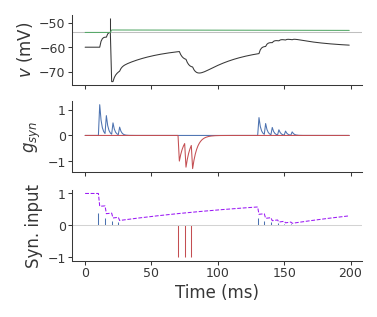

In [49]:
legend_loc = 'lower right'
fig, axs = plt.subplots(3, figsize=(2.4,2.0), dpi=150, sharex=True, constrained_layout=True)
axs[0].axhline(params['v_threshold']/mV, color='grey', lw=plt.rcParams['axes.linewidth'], alpha=.5)
for spike in spikes:
    axs[0].vlines(spike/ms, params['v_threshold']/mV, (params['v_rest']+2*(params['v_threshold']-params['v_rest']))/mV, color=_new_black)
axs[0].plot([], color='k', label='Spike')
axs[0].plot(time/ms, v/mV, color=_new_black, label='Membrane voltage ($\\tau$ = 30 ms)')
axs[0].plot(time/ms, (th_adapt + params['v_threshold'])/mV, label='Firing threshold ($\\tau$ = 1 s)', c=colors['Threshold'])
# axs[0].legend(loc=legend_loc)
axs[0].set_ylabel('$v$ (mV)')

axs[1].plot(time/ms, g_exc, label='$g_{exc}$ ($\\tau$ = 2 ms)', c='b')
axs[1].plot(time/ms, -g_inh, label='$g_{inh}$ ($\\tau$ = 4 ms)', c='r')
# axs[1].legend(loc=legend_loc)
axs[1].set_ylabel('$g_{syn}$')

axs[2].plot(time/ms, xr_pre, '--', c=colors['Depression'], label='Synaptic depression factor ($\\tau$ = 150 ms)')
axs[2].vlines(espikes_pre/ms, 0, params['U']*xr_pre[((espikes_pre+defaultclock.dt/2)/defaultclock.dt).astype(int)], color='b')
axs[2].plot([], c='b', label='Synaptic input (exc)')
axs[2].vlines(ispikes_pre/ms, -1, 0, color='r')
axs[2].plot([], c='r', label='Synaptic input (inh)')
axs[2].axhline(0, color='lightgrey', lw=plt.rcParams['axes.linewidth'])
# axs[2].legend(loc=legend_loc)
axs[2].set_ylabel('Syn. input')

plt.xlabel('Time (ms)')
sns.despine()
plt.savefig('fig1c.svg')

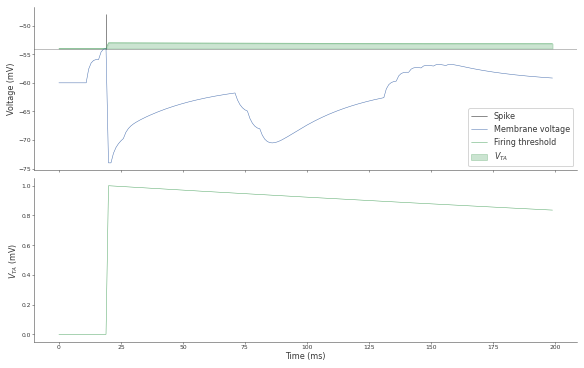

In [15]:
fig, axs = plt.subplots(2, figsize=(8,5), sharex=True, constrained_layout=True)
axs[0].axhline(params['v_threshold']/mV, color='grey', lw=1, alpha=.5)
for spike in spikes:
    axs[0].vlines(spike/ms, params['v_threshold']/mV, (params['v_rest']+2*(params['v_threshold']-params['v_rest']))/mV, color='k')
axs[0].plot([], color='k', label='Spike')
axs[0].plot(time/ms, v/mV, label='Membrane voltage')
axs[0].plot(time/ms, (th_adapt + params['v_threshold'])/mV, label='Firing threshold', c=colors['Threshold'])
axs[0].fill_between(time/ms, params['v_threshold']/mV, (th_adapt + params['v_threshold'])/mV,
                    label='$V_{TA}$', color=colors['Threshold'], alpha=.3)
axs[0].legend(loc=legend_loc)
axs[0].set_ylabel('Voltage (mV)')

axs[1].plot(time/ms, th_adapt/mV, label='$V_TA$', c=colors['Threshold'])
axs[1].set_ylabel('$V_{TA}$ (mV)')

plt.xlabel('Time (ms)')
sns.despine()

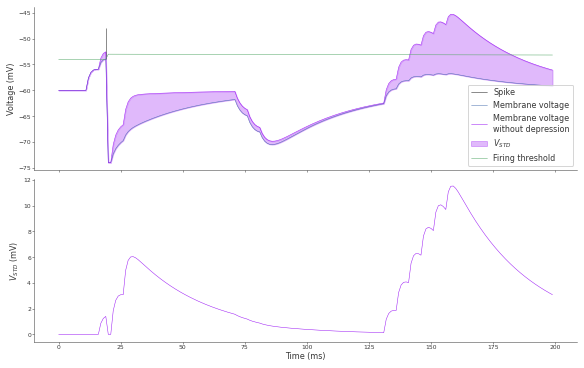

In [16]:
fig, axs = plt.subplots(2, figsize=(8,5), sharex=True, constrained_layout=True)
for spike in spikes:
    axs[0].vlines(spike/ms, params['v_threshold']/mV, (params['v_rest']+2*(params['v_threshold']-params['v_rest']))/mV, color='k')
axs[0].plot([], color='k', label='Spike')
axs[0].plot(time/ms, v/mV, label='Membrane voltage')
axs[0].plot(time/ms, u/mV, label='Membrane voltage\nwithout depression', color=colors['Depression'])
axs[0].fill_between(time/ms, v/mV, u/mV, color=colors['Depression'], alpha=.3, label='$V_{STD}$')
axs[0].plot(time/ms, (th_adapt + params['v_threshold'])/mV, label='Firing threshold', c=colors['Threshold'])
axs[0].legend(loc=legend_loc)
axs[0].set_ylabel('Voltage (mV)')

axs[1].plot(time/ms, depression/mV, c=colors['Depression'])
axs[1].set_ylabel('$V_{STD}$ (mV)')

plt.xlabel('Time (ms)')
sns.despine()

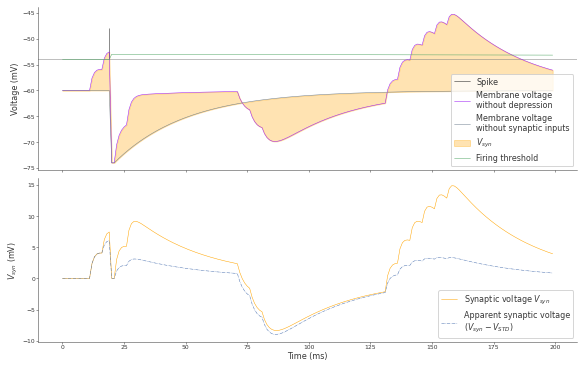

In [17]:
fig, axs = plt.subplots(2, figsize=(8,5), sharex=True, constrained_layout=True)
axs[0].axhline(params['v_threshold']/mV, color='grey', lw=1, alpha=.5)
for spike in spikes:
    axs[0].vlines(spike/ms, params['v_threshold']/mV, (params['v_rest']+2*(params['v_threshold']-params['v_rest']))/mV, color='k')
axs[0].plot([], color='k', label='Spike')
axs[0].plot(time/ms, u/mV, label='Membrane voltage\nwithout depression', color=colors['Depression'])
axs[0].plot(time/ms, (u-synapse)/mV, label='Membrane voltage\nwithout synaptic inputs', color=colors['Reset'])
axs[0].fill_between(time/ms, u/mV, (u-synapse)/mV, label='$V_{syn}$', color=colors['Synapses'], alpha=.3)
axs[0].plot(time/ms, (th_adapt + params['v_threshold'])/mV, label='Firing threshold', c=colors['Threshold'])
axs[0].legend(loc=legend_loc)
axs[0].set_ylabel('Voltage (mV)')

axs[1].plot(time/ms, synapse/mV, c=colors['Synapses'], label='Synaptic voltage $V_{syn}$')
axs[1].plot(time/ms, (synapse-depression)/mV, '-.', label='Apparent synaptic voltage\n($V_{syn} - V_{STD}$)')
axs[1].legend(loc=legend_loc)
axs[1].set_ylabel('$V_{syn}$ (mV)')

plt.xlabel('Time (ms)')
sns.despine()

In [18]:
# tslice = slice(None)
# buildup = dict(zip(('static', 'TA', 'STD', 'vsyn', 'usyn', 'reset', 'output_measures', 'output-TA', 'output-STD', 'output-Syn', 'output-Reset'), itertools.count()))
# for B in buildup.values():
#     if B < buildup['vsyn']:
#         fig, ax = plt.subplots(figsize=(15,4), dpi=150)
#         axs = [ax]
#     elif B < buildup['output_measures']:
#         fig, axs = plt.subplots(2, figsize=(15,8), sharex=True, dpi=150)
#     else:
#         fig, axs = plt.subplots(3, figsize=(15,12), sharex=True, dpi=150)
#     plt.xlabel('Time (ms)')

#     axs[0].axhline((params['v_threshold'])/mV, label='$\\theta_0$: Threshold without adaptation (¹)', color='grey')
#     axs[0].plot(time[tslice]/ms, v[tslice]/mV, label='$v$: Voltage with depression', color='C0')
#     axs[0].plot([], label='Spike', color='k')
#     if B >= buildup['TA']:
#         axs[0].plot(time[tslice]/ms, (th_adapt[tslice] + params['v_threshold'])/mV,
#                     label='$\\hat \\theta = \\theta_0+\\theta_{TA}$: Threshold with adaptation', color=colors['Threshold'])
#     if B >= buildup['STD']:
#         axs[0].plot(time[tslice]/ms, u[tslice]/mV, label='$u$: Voltage without depression (¹)', color='C1')
#     for spike in spikes:
#         if spike >= time[tslice][0] and spike <= time[tslice][-1]:
#             axs[0].vlines(spike/ms, params['v_threshold']/mV, (params['v_rest']+2*(params['v_threshold']-params['v_rest']))/mV, color='k')
#     axs[0].plot([], ls='', label='(¹) Hypothetical.')
#     axs[0].legend(loc='lower right', fontsize=10)
#     axs[0].set_ylabel('Voltage (mV)')
#     lo, hi = (
#         np.min([v[tslice], th_adapt[tslice]+params['v_threshold'], u[tslice]])/mV,
#         np.max([v[tslice], th_adapt[tslice]+params['v_threshold'], u[tslice]])/mV)
#     padding = 0.05*(hi-lo)
#     axs[0].set_ylim(lo-padding, hi+padding)

#     if B >= buildup['vsyn']:
#         axs[1].plot(time[tslice]/ms, vsyn[tslice]/mV, label='$S_v$: Synaptic contribution to v')
#         if B >= buildup['usyn']:
#             axs[1].plot(time[tslice]/ms, synapse[tslice]/mV, label='$S_u$: Synaptic contribution to u')
#         if B >= buildup['reset']:
#             axs[1].plot(time[tslice]/ms, reset[tslice]/mV, label='$V_{reset}$', c='r')
#         axs[1].legend(loc='lower right', fontsize=10)
#         axs[1].set_ylabel('Voltage (mV)')
#         lo, hi = (
#             np.min([vsyn[tslice], synapse[tslice], reset[tslice]])/mV,
#             np.max([vsyn[tslice], synapse[tslice], reset[tslice]])/mV)
#         padding = 0.05*(hi-lo)
#         axs[1].set_ylim(lo-padding, hi+padding)

#     if B >= buildup['output_measures']:
#         axs[2].axhline(0, color='grey')
#         if B >= buildup['output-STD']:
#             axs[2].plot(time[tslice]/ms, depression[tslice]/mV, c=colors['Depression'], label='$V_{STD}$ := $u-v$')
#         if B >= buildup['output-TA']:
#             axs[2].plot(time[tslice]/ms, threshold[tslice]/mV, c=colors['Threshold'], label='$V_{TA}$ := $\\theta_{TA}$')
#         if B >= buildup['output-Syn']:
#             axs[2].plot(time[tslice]/ms, synapse[tslice]/mV, c='magenta', label='$V_{syn}$ := $S_u$')
#         if B >= buildup['output-Reset']:
#             axs[2].plot(time[tslice]/ms, reset[tslice]/mV, c='red', label='$V_{reset}$ := $v - v_{rest} - S_v$')
#         axs[2].set_ylabel('Voltage contributions (mV)')
#         lo, hi = (
#             np.min([depression[tslice], threshold[tslice], synapse[tslice], reset[tslice]])/mV,
#             np.max([depression[tslice], threshold[tslice], synapse[tslice], reset[tslice]])/mV)
#         padding = 0.05*(hi-lo)
#         axs[2].set_ylim(lo-padding, hi+padding)
    
#     if B > buildup['output_measures']:
#         axs[2].legend(loc='lower right', fontsize=10)

# Effect of synaptic depression

In [19]:
defaultclock.dt = params['dt']
Nexcit = 20
params.update(N_exc=Nexcit)
espikes_pre = ([0]*100)*ms
excit = SpikeGeneratorGroup(Nexcit, np.arange(Nexcit), np.zeros(Nexcit)*ms)
Net = Network(excit)
neuron = model.create_excitatory(Net, [0]*meter, [0]*meter, params, defaultclock, ('v', 'u', 'vsyn'), False, '')
s_exc = model.make_exc_synapse(excit, neuron, np.arange(Nexcit), np.arange(Nexcit), params['w_exc_mean'], params, with_u=True)
xinit = np.linspace(0, 1, Nexcit)
s_exc.xr = xinit
statemon = StateMonitor(neuron, list(neuron.dynamic_variables.keys()), True)
Net.add(s_exc, statemon)

In [20]:
tmax = 10*ms
Net.run(tmax, namespace={})
time = np.arange(0*second, tmax, defaultclock.dt)

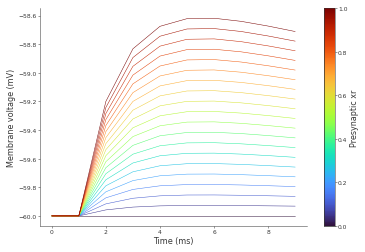

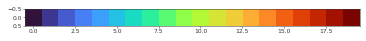

In [21]:
fig, ax = plt.subplots()
ax.set_prop_cycle('color', [plt.cm.turbo(i) for i in np.linspace(0, 1, Nexcit)])
ax.plot(time/ms, statemon.v.T/mV)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Membrane voltage (mV)')
fig2, ax2 = plt.subplots()
m = ax2.imshow(xinit[None,:], cmap='turbo')
fig.colorbar(m, ax=ax, label='Presynaptic xr')
sns.despine(fig)

1.38168353 * mvolt

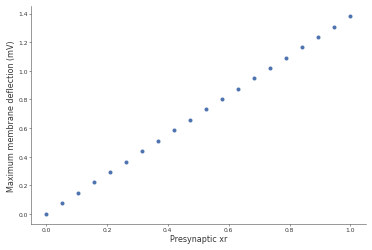

In [22]:
plt.plot(xinit, (statemon.v.max(1) - statemon.v[:, 0])/mV, '.')
plt.xlabel('Presynaptic xr')
plt.ylabel('Maximum membrane deflection (mV)')
sns.despine()
statemon.v[-1].max() - statemon.v[-1,0]